In [1]:
import findspark
findspark.init()
import pyspark
import re
import numpy as np
import scipy.sparse as sps
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.mllib.feature import Normalizer
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.tree import RandomForest, GradientBoostedTrees
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
import os
port = 4040 + hash(os.getcwd().split("/")[2])%200
config = pyspark.SparkConf().set('spark.executor.memory', '512M')\
         .set('spark.cores.max', '20')\
         .set('spark.port.maxRetries','200')\
         .set('spark.ui.port', port)    
print port,     os.getcwd().split("/")[2]

4047 siz216


In [3]:
sc = pyspark.SparkContext(appName="Project_3_Modeling", master='spark://polyp1:7077',conf = config )

In [4]:
data = sc.textFile("cleanInput.csv")

In [5]:
head=data.first()
datanohead = data.filter(lambda x: x!=head)
datanohead.take(4)
data = datanohead.map(lambda x:x.split(','))

In [6]:
print head.split(",")

[u'MONTH', u'DAY_OF_WEEK', u'SCHEDULED_DEPARTURE_HOUR', u'SCHEDULED_TIME', u'DISTANCE', u'SCHEDULED_ARRIVAL_HOUR', u'ARRIVAL_DELAY_FLAG', u'DEPARTURE_DELAY_FLAG', u'AIRLINE_AA', u'AIRLINE_AS', u'AIRLINE_B6', u'AIRLINE_DL', u'AIRLINE_EV', u'AIRLINE_F9', u'AIRLINE_HA', u'AIRLINE_MQ', u'AIRLINE_NK', u'AIRLINE_OO', u'AIRLINE_UA', u'AIRLINE_US', u'AIRLINE_VX', u'AIRLINE_WN', u'ORIGIN_AIRPORT_ABE', u'ORIGIN_AIRPORT_ABI', u'ORIGIN_AIRPORT_ABQ', u'ORIGIN_AIRPORT_ABR', u'ORIGIN_AIRPORT_ABY', u'ORIGIN_AIRPORT_ACK', u'ORIGIN_AIRPORT_ACT', u'ORIGIN_AIRPORT_ACV', u'ORIGIN_AIRPORT_ACY', u'ORIGIN_AIRPORT_ADK', u'ORIGIN_AIRPORT_ADQ', u'ORIGIN_AIRPORT_AEX', u'ORIGIN_AIRPORT_AGS', u'ORIGIN_AIRPORT_AKN', u'ORIGIN_AIRPORT_ALB', u'ORIGIN_AIRPORT_ALO', u'ORIGIN_AIRPORT_AMA', u'ORIGIN_AIRPORT_ANC', u'ORIGIN_AIRPORT_APN', u'ORIGIN_AIRPORT_ASE', u'ORIGIN_AIRPORT_ATL', u'ORIGIN_AIRPORT_ATW', u'ORIGIN_AIRPORT_AUS', u'ORIGIN_AIRPORT_AVL', u'ORIGIN_AIRPORT_AVP', u'ORIGIN_AIRPORT_AZO', u'ORIGIN_AIRPORT_BDL', u'ORIG

In [16]:
headers = head.split(",")[:6]+head.split(",")[7:]
headers

[u'MONTH',
 u'DAY_OF_WEEK',
 u'SCHEDULED_DEPARTURE_HOUR',
 u'SCHEDULED_TIME',
 u'DISTANCE',
 u'SCHEDULED_ARRIVAL_HOUR',
 u'DEPARTURE_DELAY_FLAG',
 u'AIRLINE_AA',
 u'AIRLINE_AS',
 u'AIRLINE_B6',
 u'AIRLINE_DL',
 u'AIRLINE_EV',
 u'AIRLINE_F9',
 u'AIRLINE_HA',
 u'AIRLINE_MQ',
 u'AIRLINE_NK',
 u'AIRLINE_OO',
 u'AIRLINE_UA',
 u'AIRLINE_US',
 u'AIRLINE_VX',
 u'AIRLINE_WN',
 u'ORIGIN_AIRPORT_ABE',
 u'ORIGIN_AIRPORT_ABI',
 u'ORIGIN_AIRPORT_ABQ',
 u'ORIGIN_AIRPORT_ABR',
 u'ORIGIN_AIRPORT_ABY',
 u'ORIGIN_AIRPORT_ACK',
 u'ORIGIN_AIRPORT_ACT',
 u'ORIGIN_AIRPORT_ACV',
 u'ORIGIN_AIRPORT_ACY',
 u'ORIGIN_AIRPORT_ADK',
 u'ORIGIN_AIRPORT_ADQ',
 u'ORIGIN_AIRPORT_AEX',
 u'ORIGIN_AIRPORT_AGS',
 u'ORIGIN_AIRPORT_AKN',
 u'ORIGIN_AIRPORT_ALB',
 u'ORIGIN_AIRPORT_ALO',
 u'ORIGIN_AIRPORT_AMA',
 u'ORIGIN_AIRPORT_ANC',
 u'ORIGIN_AIRPORT_APN',
 u'ORIGIN_AIRPORT_ASE',
 u'ORIGIN_AIRPORT_ATL',
 u'ORIGIN_AIRPORT_ATW',
 u'ORIGIN_AIRPORT_AUS',
 u'ORIGIN_AIRPORT_AVL',
 u'ORIGIN_AIRPORT_AVP',
 u'ORIGIN_AIRPORT_AZO',
 u'ORI

In [7]:
#print data.take(1)

In [8]:
data = data.map(lambda x:[float(i) for i in x[:]])

In [9]:
def select(x):
    label = x[6]
    feature = [i for i in x[:6]] + [i for i in x[7:]]
    return LabeledPoint(label,feature)

lp = data.map(select)

In [10]:
(traindata, validdata) = lp.randomSplit([0.7, 0.3])

### LR Model

In [11]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel

model = LogisticRegressionWithLBFGS.train(traindata)

In [12]:
trainpredicttrainLG = traindata.map(lambda p: (p.label, model.predict(p.features)))
trainErr = trainpredicttrainLG.filter(lambda lp: lp[0] != lp[1]).count() / float(traindata.count())
print("Training Error = " + str(trainErr))

Training Error = 0.206757746314


In [13]:
labelsAndPredstestLG = validdata.map(lambda p: (p.label, model.predict(p.features)))
testErr = labelsAndPredstestLG.filter(lambda lp: lp[0] != lp[1]).count() / float(validdata.count())
print("Testing Error = " + str(testErr))
#print labelsAndPreds.collect()

Testing Error = 0.207970852355


In [ ]:
for i,j in enumerate(header.split(',')):
    print i,j

In [20]:
w = model.weights.toArray()


In [25]:
res = zip(headers, w)
new = sorted(res,key = lambda x: -abs(x[1]))
new

[(u'DEPARTURE_DELAY_FLAG', 2.7107853117246323),
 (u'ORIGIN_AIRPORT_HYA', -2.6244292385100505),
 (u'ORIGIN_AIRPORT_DLG', -2.152228363995126),
 (u'DESTINATION_AIRPORT_MVY', -2.038836877343761),
 (u'ORIGIN_AIRPORT_CNY', -2.0310242034648853),
 (u'ORIGIN_AIRPORT_VEL', -1.8995393911596472),
 (u'DESTINATION_AIRPORT_VEL', -1.826432494038031),
 (u'DESTINATION_AIRPORT_IMT', -1.779832120033908),
 (u'ORIGIN_AIRPORT_YAK', -1.6780203618092135),
 (u'DESTINATION_AIRPORT_DLG', -1.600996842568211),
 (u'DESTINATION_AIRPORT_ITH', -1.452048237116399),
 (u'ORIGIN_AIRPORT_GUM', -1.430909955701191),
 (u'ORI_STATE_GU', -1.430909955701191),
 (u'DESTINATION_AIRPORT_BJI', -1.3952790633269454),
 (u'DESTINATION_AIRPORT_BRD', -1.3025708480267448),
 (u'DESTINATION_AIRPORT_HYS', -1.2830844490528448),
 (u'ORIGIN_AIRPORT_ITO', -1.2804864316207192),
 (u'DESTINATION_AIRPORT_CLD', -1.2293767159907705),
 (u'DESTINATION_AIRPORT_GST', -1.2048820259817192),
 (u'ORIGIN_AIRPORT_LIH', -1.1717094296303527),
 (u'ORIGIN_AIRPORT_MVY'

In [33]:
print trainpredicttrainLG.take(50)

[(0.0, 0), (0.0, 1), (0.0, 0), (0.0, 0), (1.0, 1), (0.0, 0), (1.0, 1), (0.0, 0), (0.0, 0), (1.0, 1), (1.0, 1), (0.0, 0), (1.0, 0), (0.0, 0), (0.0, 1), (0.0, 0), (0.0, 0), (0.0, 1), (1.0, 0), (0.0, 0), (0.0, 0), (1.0, 1), (1.0, 1), (0.0, 0), (1.0, 1), (0.0, 1), (1.0, 1), (0.0, 0), (0.0, 0), (0.0, 1), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 1), (0.0, 0), (0.0, 0), (0.0, 0), (1.0, 0), (0.0, 0), (0.0, 0), (0.0, 1), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (1.0, 1), (0.0, 0), (0.0, 0), (1.0, 1)]


In [39]:
paramLR = [0.0001, 0.0005, 0.001, 0.01]
lrTestError = []
lrTrainError = []
for para in paramLR:
    modelLR = LogisticRegressionWithSGD.train(traindata,iterations= 200, step=1, regParam = para)
    predictLRTest = validdata.map(lambda p: (p.label, modelLR.predict(p.features)))
    predictLRTrain = traindata.map(lambda p: (p.label, modelLR.predict(p.features)))
    errorTest = predictLRTest.filter(lambda lp: lp[0] != lp[1]).count() / float(validdata.count())
    errorTrain = predictLRTrain.filter(lambda lp: lp[0] != lp[1]).count() / float(traindata.count())
    lrTestError.append(errorTest)
    lrTrainError.append(errorTest)
    
print lrTestError
print lrTrainError

[0.3723258776991375, 0.6276741223008625, 0.6276741223008625, 0.6276741223008625]
[0.3723258776991375, 0.6276741223008625, 0.6276741223008625, 0.6276741223008625]


### RF Model

In [34]:
from pyspark.mllib.tree import RandomForest, RandomForestModel

model1 = RandomForest.trainClassifier(traindata, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=3, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=4, maxBins=32)

In [35]:
predictionstrainRF = model1.predict(traindata.map(lambda x: x.features))
labelsAndPredictionstrainRF = traindata.map(lambda lp: lp.label).zip(predictionstrainRF)
trainErr = labelsAndPredictionstrainRF.filter(
    lambda lp: lp[0] != lp[1]).count() / float(traindata.count())
print('Train Error = ' + str(trainErr))

Train Error = 0.233599264191


In [36]:
predictionstestRF = model1.predict(validdata.map(lambda x: x.features))
labelsAndPredictionstestRF = validdata.map(lambda lp: lp.label).zip(predictionstestRF)
testErr = labelsAndPredictionstestRF.filter(
    lambda lp: lp[0] != lp[1]).count() / float(validdata.count())
print('Test Error = ' + str(testErr))

Test Error = 0.231960722839


In [37]:
print labelsAndPredictionstestRF.take(5)

[(1.0, 0.0), (0.0, 0.0), (0.0, 0.0), (1.0, 1.0), (0.0, 0.0)]


In [40]:
trees = [5, 10, 20, 30, 40]
rfTestError = []
rfTrainError = []
for j in trees:
    modelRF = RandomForest.trainClassifier(traindata, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=j, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=4, maxBins=32)
    predictionstrainRF = modelRF.predict(traindata.map(lambda x: x.features))
    predictionstestRF = modelRF.predict(validdata.map(lambda x: x.features))
    labelsAndPredictionstrainRF = traindata.map(lambda lp: lp.label).zip(predictionstrainRF)
    labelsAndPredictionstestRF = validdata.map(lambda lp: lp.label).zip(predictionstestRF)
    testErr = labelsAndPredictionstestRF.filter(lambda lp: lp[0] != lp[1]).count() / float(validdata.count())
    trainErr = labelsAndPredictionstrainRF.filter(lambda lp: lp[0] != lp[1]).count() / float(traindata.count())
    rfTestError.append(testErr)
    rfTrainError.append(trainErr)

print rfTestError
print rfTrainError

[0.3723258776991375, 0.3720090188047415, 0.3723258776991375, 0.3723258776991375, 0.3723258776991375]
[0.3717047853272435, 0.37134059430262417, 0.3717047853272435, 0.3717047853272435, 0.3717047853272435]


### GBT Model

In [27]:
bestGBT = GradientBoostedTrees.trainClassifier(traindata,{})

KeyboardInterrupt: 

In [ ]:
predictionstestGBT = bestGBT.predict(validdata.map(lambda x: x.features))
labelsAndPredictionstestGBT = validdata.map(lambda lp: lp.label).zip(predictionstestGBT)
testErr = labelsAndPredictionstestGBT.filter(
    lambda lp: lp[0] != lp[1]).count() / float(validdata.count())
print('Test Error = ' + str(testErr))

### K means Clustering

In [41]:
from pyspark.mllib.clustering import KMeans, KMeansModel
featuredata = lp.map(lambda x:x.features)
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sum([x**2 for x in (point - center)])
ks=[]
es=[]
for k in range(1,20,1):
    clusters = KMeans.train(featuredata, k, maxIterations=10, initializationMode="random", seed=100)
    WSSSE = featuredata.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    ks.append(k)
    es.append(WSSSE)

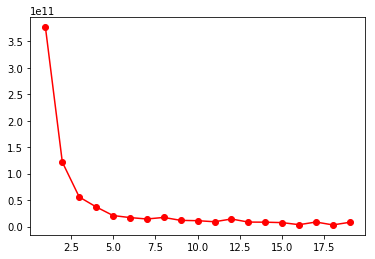

In [43]:
plt.plot(ks,es,"r-o")


In [44]:
clusters = KMeans.train(featuredata, 5, maxIterations=10, initializationMode="random", seed=100)

In [ ]:
sc.stop()